# Export vehicle volumne at FR-Capitole
- This script is used to export vehicle data from UTD19 dataset.

In [1]:
import re
import os
import pandas as pd
import numpy as np
import warnings
import xarray as xr
home_path = '/gws/nopw/j04/duicv/yuansun/'

In [2]:
df_meta_original = pd.read_csv(f'{home_path}dataset/UTD19/detectors_public.csv')
df_meta_original.head()

,detid,length,pos,fclass,road,limit,citycode,lanes,linkid,long,lat
0,U1-52G,0.196037,0.005512,secondary,Gögginger Straße,50,augsburg,1.0,72.0,10.889553,48.359957
1,U1-51G,0.130039,0.004013,secondary,Gögginger Straße,50,augsburg,1.0,73.0,10.889601,48.359945
2,U1-52L,0.155863,0.022228,secondary,Gögginger Straße,50,augsburg,1.0,70.0,10.889356,48.359876
3,U1-51L,0.197675,0.021889,secondary,Gögginger Straße,50,augsburg,1.0,71.0,10.889396,48.359862
4,U1-62,0.065183,0.024465,secondary,Rosenaustraße,50,augsburg,1.0,68.0,10.889361,48.360578


In [3]:
capitole = df_meta_original[df_meta_original['long']==1.4454988] 
capitole
# lanes: Number of lanes monitored.
# lanes = 2.0

,detid,length,pos,fclass,road,limit,citycode,lanes,linkid,long,lat
20478,38,0.232518,0.223456,residential,Rue Lafayette,30,toulouse,2.0,172.0,1.445499,43.604907


In [5]:
chunksize = 100000  # Adjust based on available memory
df_list = []

for chunk in pd.read_csv(f'{home_path}0_urban_traffic/input_process/split_rawdata/city_data_noerror/toulouse.csv', chunksize=chunksize):
    df_list.append(chunk)

df_toulouse = pd.concat(df_list, ignore_index=True)

In [4]:
df_toulouse = pd.read_csv(f'{home_path}0_urban_traffic/input_process/split_rawdata/city_data_noerror/toulouse.csv')
df_toulouse.head()
# flow: Flow in vehicles per hour for that detector. A reporting detector can span several lanes. 
# The flow given in the data set is adjusted for this, i.e. it gives flow per hour and lane (veh/h-lane)).

,day,interval,detid,flow,occ,error,city,speed
0,2008-06-20,81900,1,0.0,0.000000,NaN,toulouse,NaN
1,2008-06-20,84420,1,140.0,0.005556,NaN,toulouse,NaN
2,2008-05-30,43560,1,180.0,0.011111,NaN,toulouse,NaN
3,2008-06-06,39060,1,180.0,0.016667,NaN,toulouse,NaN
4,2008-06-13,26280,1,180.0,0.005556,NaN,toulouse,NaN


In [5]:
df_capitole = df_toulouse[df_toulouse['detid']==38]
df_capitole.to_csv('FR-Capitole.csv', index=False)
df_capitole

,day,interval,detid,flow,occ,error,city,speed
68368,2008-06-20,31140,38,380.0,0.044444,NaN,toulouse,NaN
68369,2008-05-30,1980,38,140.0,0.022222,NaN,toulouse,NaN
68370,2008-05-23,66960,38,100.0,0.005556,NaN,toulouse,NaN
68371,2008-06-06,65160,38,80.0,0.011111,NaN,toulouse,NaN
68372,2008-06-13,82800,38,180.0,0.022222,NaN,toulouse,NaN
...,...,...,...,...,...,...,...,...
71325,2008-06-13,59040,38,180.0,0.022222,NaN,toulouse,NaN
71326,2008-05-30,5040,38,120.0,0.011111,NaN,toulouse,NaN
71327,2008-06-13,44460,38,220.0,0.027778,NaN,toulouse,NaN
71328,2008-05-23,69120,38,320.0,0.033333,NaN,toulouse,NaN


## process raw data at Capitole

In [24]:
df_capitole = pd.read_csv('FR-Capitole.csv')
df_capitole['timestamp'] = pd.to_datetime(df_capitole['day']) + pd.to_timedelta(df_capitole['interval'], unit='s')
df_capitole_clean = df_capitole[['timestamp', 'flow']].sort_values(by='timestamp', ascending=True)
df_capitole_clean = df_capitole_clean.reset_index(drop=True)
df_capitole_clean['vehicles_per_interval'] = df_capitole_clean['flow'] * (3 / 60) # 3 minutes per interval
df_capitole_clean['date'] = df_capitole_clean['timestamp'].dt.date
df_capitole_clean['hour'] = df_capitole_clean['timestamp'].dt.hour
df_capitole_clean['day_of_week'] = df_capitole_clean['timestamp'].dt.day_name() # all Fridays
df_capitole_clean

,timestamp,flow,vehicles_per_interval,date,hour,day_of_week
0,2008-05-16 00:00:00,120.0,6.0,2008-05-16,0,Friday
1,2008-05-16 00:03:00,100.0,5.0,2008-05-16,0,Friday
2,2008-05-16 00:06:00,110.0,5.5,2008-05-16,0,Friday
3,2008-05-16 00:09:00,120.0,6.0,2008-05-16,0,Friday
4,2008-05-16 00:15:00,140.0,7.0,2008-05-16,0,Friday
...,...,...,...,...,...,...
2957,2008-06-27 23:45:00,260.0,13.0,2008-06-27,23,Friday
2958,2008-06-27 23:48:00,220.0,11.0,2008-06-27,23,Friday
2959,2008-06-27 23:51:00,300.0,15.0,2008-06-27,23,Friday
2960,2008-06-27 23:54:00,220.0,11.0,2008-06-27,23,Friday


In [7]:
daily_flow = df_capitole_clean.groupby('date')['vehicles_per_interval'].sum()
daily_flow

date
2008-05-16    4939.35
2008-05-23    4474.50
2008-05-30    3853.00
2008-06-06    4405.00
2008-06-13    4664.35
2008-06-20    5058.90
2008-06-27    3434.70
Name: vehicles_per_interval, dtype: float64

In [8]:
daily_flow_AADT = daily_flow.mean().item()
daily_flow_AADT

4404.257142857143

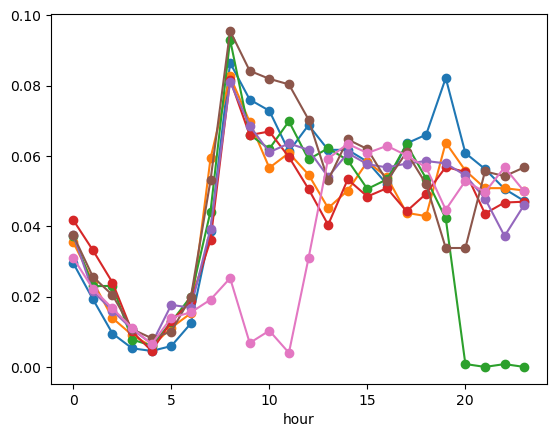

In [22]:
for date in np.unique(df_capitole_clean['date']):
    df_date = df_capitole_clean[df_capitole_clean['date'] == date]
    date_daily_flow = df_capitole_clean.groupby('date')['vehicles_per_interval'].sum()
    date_daily_flow_AADT = date_daily_flow.mean().item()
    date_diurnal = df_date.groupby('hour')['flow'].mean() / date_daily_flow_AADT
    date_diurnal.plot(marker='o')

hour
0     0.04
1     0.02
2     0.02
3     0.01
4     0.01
5     0.01
6     0.02
7     0.04
8     0.08
9     0.07
10    0.06
11    0.06
12    0.06
13    0.05
14    0.06
15    0.06
16    0.05
17    0.06
18    0.05
19    0.05
20    0.05
21    0.05
22    0.04
23    0.04
Name: flow, dtype: float64

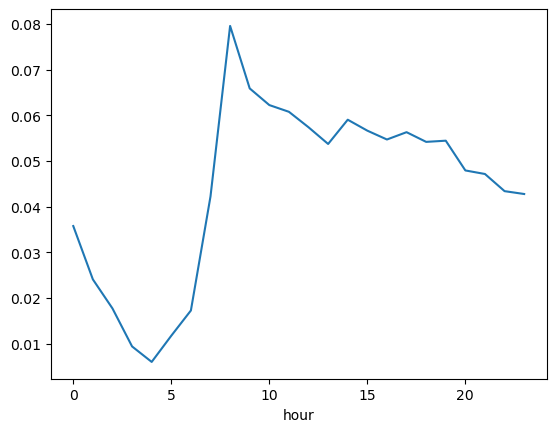

In [28]:
df_capitole_diurnal = df_capitole_clean.groupby('hour')['flow'].mean() / daily_flow_AADT
df_capitole_diurnal.plot()
df_capitole_diurnal.round(2)